In [1]:
import dask as da
import dask.dataframe as daskdf
import dask.array as daa
import dask.dataframe as dd
import dask.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import sklearn as sk
import numpy as np
import dask_ml.preprocessing as dm_pre
import dask_ml.cluster as dm_cluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from scipy.stats import pearsonr
import time

In [2]:
def load_data():
    print("Loading data...")
    start = time.time()
    df = dd.read_csv("ar41_for_ulb.csv", sep=';')
    end = time.time()
    
    print("Data loaded in {} seconds".format(end - start))
    return df

ddf = load_data()
ddf = ddf.drop(columns=['X'])

# Select Data: Filtering out all data before January 2023
def select_data(df):
    print("Selecting data...")
    ddf = df[df['timestamps_UTC'] >= '2023-01-01']
    # to drop the erratic data and keep only those in 10-90 percentile for every feature
    for col in ddf.columns:
        if col not in ['timestamps_UTC', 'lat', 'lon', 'mapped_veh_id']:
            ddf = ddf[(ddf[col] > ddf[col].quantile(0.001)) & (ddf[col] < ddf[col].quantile(0.999))]

    return ddf

ddfprep = select_data(ddf)
#index fix 
ddfprep = ddfprep.reset_index(drop=True)
# Drop duplicates and handle missing values
ddf = ddf.drop_duplicates()
ddf = ddf.dropna()
ddf = ddf.fillna(0)

# Assuming ddfprep is your Dask DataFrame
ddfprep['timestamps_UTC'] = dd.to_datetime(ddfprep['timestamps_UTC'], errors='coerce')
ddfprep = ddfprep.sort_values('timestamps_UTC')

def per_group(df):
    print("Processing group...")
    # Rééchantillonner les données avec une moyenne sur des intervalles de 30 secondes
    resampled_df = df.set_index('timestamps_UTC').resample('30T').agg({
        'mapped_veh_id': 'first',  # Include the vehicle ID column
        'lat': 'mean',
        'lon': 'mean',
        'RS_E_RPM_PC1': 'mean',
        'RS_E_RPM_PC2': 'mean',
        'RS_E_InAirTemp_PC1': 'mean',
        'RS_E_InAirTemp_PC2': 'mean',
        'RS_E_OilPress_PC1': 'mean',
        'RS_E_OilPress_PC2': 'mean',
        'RS_E_WatTemp_PC1': 'mean',
        'RS_E_WatTemp_PC2': 'mean',
        'RS_T_OilTemp_PC1': 'mean',
        'RS_T_OilTemp_PC2': 'mean'        
    })
    # Supprimer les lignes contenant des NaN
    resampled_df = resampled_df.dropna()
    
    return resampled_df

# Appliquer la fonction à chaque groupe dans Dask DataFrame
print("Applying function to each group...")
result_df = ddfprep.groupby("mapped_veh_id").apply(per_group).compute()

print(result_df.head())  # Print the head of the resulting DataFrame


Loading data...
Data loaded in 0.00769495964050293 seconds
Selecting data...


In [ ]:
result_df.to_csv('preprocess_train_ts.csv', index=False)


In [ ]:
print(result_df.head())  # Print the head of the resulting DataFrame

                                   mapped_veh_id        lat       lon  \
mapped_veh_id timestamps_UTC                                            
154.0         2023-01-23 08:30:00          154.0  50.919744  3.633463   
              2023-01-23 09:00:00          154.0  51.041463  3.722477   
              2023-01-23 09:30:00          154.0  51.145655  3.632265   
              2023-01-23 10:00:00          154.0  51.149092  3.626908   
              2023-01-23 10:30:00          154.0  51.042300  3.725393   

                                   RS_E_RPM_PC1  RS_E_RPM_PC2  \
mapped_veh_id timestamps_UTC                                    
154.0         2023-01-23 08:30:00   1032.149123   1026.868421   
              2023-01-23 09:00:00    941.724138    944.008621   
              2023-01-23 09:30:00    984.032258   1002.451613   
              2023-01-23 10:00:00   1013.686441   1000.423729   
              2023-01-23 10:30:00    901.991071    910.651786   

                                

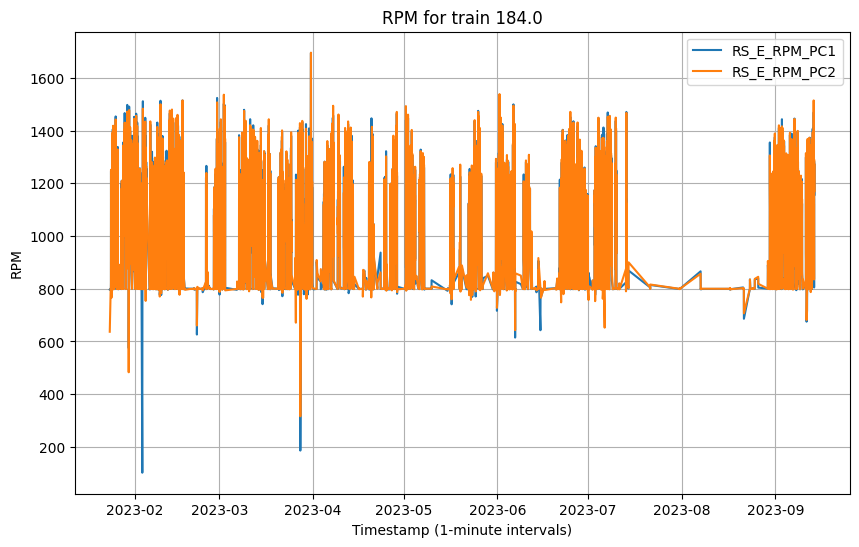

In [ ]:
# Select data for vehicle 190.0 from result_df
vehicle_190_df = result_df[result_df['mapped_veh_id'] == 184.0]

# Plot RPM for vehicle 190.0
plt.figure(figsize=(10, 6))
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), vehicle_190_df['RS_E_RPM_PC1'], label='RS_E_RPM_PC1')
plt.plot(vehicle_190_df.index.get_level_values('timestamps_UTC'), vehicle_190_df['RS_E_RPM_PC2'], label='RS_E_RPM_PC2')

# Customize the plot
plt.title('RPM for train 184.0')
plt.xlabel('Timestamp (1-minute intervals)')
plt.ylabel('RPM')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense

# Read the CSV file into a Dask DataFrame
file_path = 'path/to/preprocess_train_ts.csv'
df = dd.read_csv(file_path)

# Assuming you have a column 'mapped_veh_id' and 'timestamps_UTC', you can set them as index
df = df.set_index(['mapped_veh_id', 'timestamps_UTC'])

# Autoencoder model
input_dim = df.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the autoencoder on the entire dataset
autoencoder.fit(df, df, epochs=50, batch_size=128, shuffle=True)

# Predictions on the entire dataset
predictions = autoencoder.predict(df)

# Calculate reconstruction error for anomaly detection
reconstruction_error = ((df - predictions) ** 2).mean(axis=1)

# Define a threshold for anomaly detection (you may need to fine-tune this based on your data)
threshold = 0.1

# Identify anomalies
anomalies = df[reconstruction_error > threshold]

# Print or further process the anomalies
print("Detected Anomalies:")
print(anomalies.compute())


ModuleNotFoundError: No module named 'tensorflow'